<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/Homework%203%20-%20Logistic%20Regression%20Using%20PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 3 - Logistic Regression with PCA

The purpose of this exercise is to analyze the performances of logisitic classifier models using the original data and when Principal Component Analysis has been applied to the dataset.



## Packages & Variables

In [0]:
# Generic Packages
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# plotting Packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns

# Utility stuff
import warnings
warnings.filterwarnings('ignore')
np.random.seed(235)
from google.colab import drive, files
drive.mount('/content/gdrive')

np.random.seed(235)

In [0]:
# GLOBALS & CONSTANTS

NUM = 3
INPUT_DATA_FILE = 'ProviderInfo.csv'

GD_CODE_DIR = '/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR = 'Machine Learning & Predictive Analytics/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'
LOGS_DIR = 'logs/'
HOMEWORK_DIR = 'Homework {}/'.format(NUM)
NOTEBOOK_NAME = 'Homework {}.ipynb'.format(NUM)

MAIN_PATH = os.path.join(GD_CODE_DIR
                        ,SUBJECT_DIR
                        ,HOMEWORK_DIR)

INPUT_FILE = os.path.join(MAIN_PATH
                          ,DATA_DIR
                          ,INPUT_DATA_FILE)

NOTEBOOK_FILE = os.path.join(MAIN_PATH
                            ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH = os.path.join(MAIN_PATH
                                ,MODEL_DIR)

LOG_PATH = os.path.join(MAIN_PATH
                       ,LOGS_DIR)

## Exploratory Analysis

The data is provided in 'ProviderInfo.csv'  file which contains information surrounding the credit quality of individuals, along with characteristics of the individuals' income, assets / debts, and residence. Only the numeric variables from the data are considered in this exercise.

In [4]:
provider_data = pd.read_csv(INPUT_FILE)
provider_df = pd.DataFrame(provider_data).select_dtypes(include=np.number)
print(provider_df.head())
print('\n Columns from input file: \n {}'.format(provider_df.columns))


       ZIP         PHONE  COUNTY_SSA  BEDCERT  RESTOT  OVERALL_RATING  \
0  35653.0  2.563324e+09       290.0     57.0    51.5             5.0   
1  35150.0  2.562496e+09       600.0     85.0    74.2             3.0   
2  35768.0  2.562184e+09       350.0     50.0     NaN             1.0   
3  35206.0  2.058330e+09       360.0     92.0    79.8             2.0   
4  35111.0  2.054776e+09       360.0    103.0    98.1             3.0   

   SURVEY_RATING  QUALITY_RATING  STAFFING_RATING  RN_STAFFING_RATING  \
0            5.0             5.0              4.0                 4.0   
1            3.0             5.0              1.0                 1.0   
2            2.0             2.0              1.0                 1.0   
3            2.0             4.0              3.0                 3.0   
4            3.0             4.0              3.0                 2.0   

        ...        ADJ_AIDE  ADJ_LPN   ADJ_RN  ADJ_TOTAL  INCIDENT_CNT  \
0       ...         3.11741  1.24750  0.83853   

The columns 'ZIP', 'PHONE' and 'COUNTY_SSA' are dropped (as per TA instructions). This may be numeric in nature but they do not provide count or continuous information, which is all that will be examined in this exercise. No interaction effects are considered. Observations with NaN values in any of the variables are also removed. Some high level statistics of each variable is provided below.

In [5]:
columns2drop = np.array(['ZIP','PHONE','COUNTY_SSA'])
provider_df.drop(columns = columns2drop, inplace=True)

provider_df.replace(["NaN", 'NaT'], np.nan, inplace = True)
provider_df.dropna(how='any', axis = 0, inplace=True)

print(provider_df.describe())
print('\n Remaining columns from input file: \n {}'.format(provider_df.columns))

            BEDCERT        RESTOT  OVERALL_RATING  SURVEY_RATING  \
count  14557.000000  14557.000000    14557.000000   14557.000000   
mean     107.454214     87.349440        3.379199       2.818369   
std       60.527961     52.785727        1.384830       1.285816   
min        6.000000      2.400000        1.000000       1.000000   
25%       66.000000     52.500000        2.000000       2.000000   
50%      100.000000     79.500000        4.000000       3.000000   
75%      128.000000    109.100000        5.000000       4.000000   
max     1389.000000    754.900000        5.000000       5.000000   

       QUALITY_RATING  STAFFING_RATING  RN_STAFFING_RATING        AIDHRD  \
count    14557.000000     14557.000000        14557.000000  14557.000000   
mean         3.999107         3.165487            3.374116      2.294152   
std          1.215313         1.204848            1.270249      0.544454   
min          1.000000         1.000000            1.000000      0.000000   
25%    

The output from above show a high level summary of the 14,557 remaining observations with 26 predictors and the 1 response column, 'OVERALL_RATING'. A histogram for each predictor, and response, are generated below to check the data distribution.

Response Variable: OVERALL_RATING
Predictor Variables: ['BEDCERT' 'RESTOT' 'SURVEY_RATING' 'QUALITY_RATING' 'STAFFING_RATING'
 'RN_STAFFING_RATING' 'AIDHRD' 'VOCHRD' 'RNHRD' 'TOTLICHRD' 'TOTHRD'
 'PTHRD' 'EXP_AIDE' 'EXP_LPN' 'EXP_RN' 'EXP_TOTAL' 'ADJ_AIDE' 'ADJ_LPN'
 'ADJ_RN' 'ADJ_TOTAL' 'INCIDENT_CNT' 'CMPLNT_CNT' 'FINE_CNT' 'FINE_TOT'
 'PAYDEN_CNT' 'TOT_PENLTY_CNT']


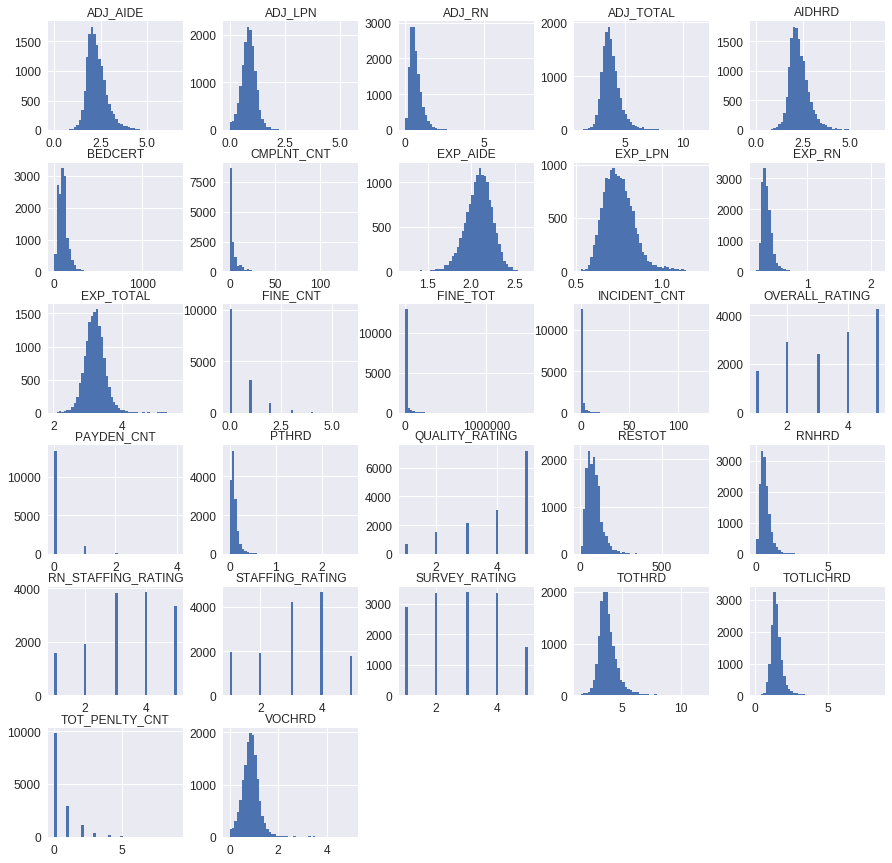

In [6]:
response = ['OVERALL_RATING'][0]
predictors =  provider_df.columns[provider_df.columns != response].values

print('Response Variable: {}'.format(response))
print('Predictor Variables: {}'.format(predictors))

def plot_df_hists(df, X_names, y_names, b = 50):  
  df.hist(bins=b, figsize=(15,15))
  plt.show()

plot_df_hists(provider_df, predictors, response)

The continuous variables are *generally* normal and the count variables are *generally*  exponential, which is not neccessary but good to know. The variables which are 'ratings' do not appear to follow any common distribution. No 'outliers' appear to be present and therefore the data is ready to be defined in the standard **X** and **y** matricies.

In [7]:
y = provider_df[response].values.ravel()
X = provider_df[predictors].values

print('\n Shape of y:   {}'.format(y.shape))
print('\n Shape of X:   {}'.format(X.shape))


 Shape of y:   (14557,)

 Shape of X:   (14557, 26)


The data is split into train and test using a ratio of 0.2. The train and test data are scaled by centering (subtracting variable mean) and normalizing (dividing by the variables standard deviation). The test set is scaled using the parameters from the train set, this is to avoid data leakage. When cross validating is important to not contaminate your validation / test set with information being used in the model generation.

In [0]:
def split_and_scale(X, y, test_size = 0.2):
  
  # use sklearn train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 235)
  
  # use sklearn standard scaler
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  
  return X_train_scaled, X_test_scaled, y_train, y_test

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y)

Next a function is created which returns the provided models score on the train & test data, along with a confusion matrix and classification report.

In [0]:
def train_model_and_score(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  yhat_test = model.predict(X_test)
  model_score_train = model.score(X_train, y_train)
  model_score_test = model.score(X_test, y_test)
  model_confusion_matrix = confusion_matrix(y_test, yhat_test)
  model_class_report = classification_report(y_test, yhat_test)
  return model_score_train, model_score_test, model_confusion_matrix, model_class_report

A Logistic Regression model is initiated using the 'lbfgs' solver, which uses cross-entropy loss on the mean model accuracy score on each subset of the data (i.e. each class). The scaled X and y data are provided to `train_model_and_score` function defined above. The outputs from the function are returned and printed.

In [10]:
log_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')

log_clf_score_train, log_clf_score_test, log_clf_conf_mx, log_clf_class_report = train_model_and_score(log_clf, X_train_scaled, y_train, X_test_scaled, y_test)

print('Model Score Train: {}'.format(round(log_clf_score_train, 4)))
print('Model Score Test:  {}'.format(round(log_clf_score_test,4)))
print('\nConfusion Matrix\n', log_clf_conf_mx)
print('\nClassification Report\n', log_clf_class_report)

Model Score Train: 0.8517
Model Score Test:  0.8489

Confusion Matrix
 [[253  82   0   0   0]
 [ 61 431  69   0   0]
 [  0  62 331  70   0]
 [  0   0  28 607  33]
 [  0   0   0  35 850]]

Classification Report
               precision    recall  f1-score   support

         1.0       0.81      0.76      0.78       335
         2.0       0.75      0.77      0.76       561
         3.0       0.77      0.71      0.74       463
         4.0       0.85      0.91      0.88       668
         5.0       0.96      0.96      0.96       885

   micro avg       0.85      0.85      0.85      2912
   macro avg       0.83      0.82      0.82      2912
weighted avg       0.85      0.85      0.85      2912



The model has a 0.85 mean accuracy score across all classes and is not overfitting the data, as seen by the very close score between the train and test set.

The fifth class ('QUALITY_RATING' of 5) has the highest score of all classes by a significant amount. This result is confirmed in the the heat map below. The class five cells are the darkest due to the higher record count. This could indicate a possible class imbalance and a downsampling could be used to try and get a better model at the potential cost of class 5 accuracy.

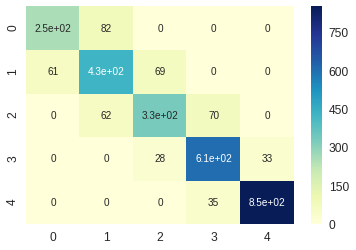

In [11]:
def make_heat_map(matrix):
    sns.heatmap(  matrix
                , annot=True
                , annot_kws={"Size" : 10}
                , cmap="YlGnBu")
    plt.figure(figsize=(10,10))
    plt.show()
    
make_heat_map(log_clf_conf_mx)

## PCA - 2 Components

Next the PCA module is used to rotate the predictor data set into ordinal axises (defined by the eigenvectors) which capture as much variance as possible. Only the first 2 components are considered in this model.

In [13]:
# import PCA object from sklearn
from sklearn.decomposition import PCA

# limit PCA object to 2 components 
pca_two = PCA(n_components=2)

# use pca object to fit & apply pca transformation to data
X_train_pca_2 = pca_two.fit_transform(X_train_scaled)
X_test_pca_2 = pca_two.transform(X_test_scaled)

print('Shape of X_train_pca_2: {}'.format(X_train_pca_2.shape))

Shape of X_train_pca_2: (11645, 2)


The data no consists of 0.8 of the original data set with 2 columns which represent the eigen values of each observation on the rotated axises.

A model is initiated again and the `fit and score` function outputs are shown below

In [16]:
log_clf_pca_2 = LogisticRegression(solver='lbfgs', multi_class='multinomial')
pca_2_model_score_train, pca_2_model_score_test, conf_mx_pca_2, class_report_pca_2 = train_model_and_score(log_clf, X_train_pca_2, y_train, X_test_pca_2, y_test)

print("Model Score Train: {}".format(round(pca_2_model_score_train,4)))
print("Test Model Score:  {}".format(round(pca_2_model_score_test, 4)))
print('\nConfusion Matrix\n', conf_mx_pca_2)
print('\nClassification Report\n', class_report_pca_2)

Model Score Train: 0.3837
Test Model Score:  0.3956

Confusion Matrix
 [[134 168   1  12  20]
 [ 93 265   1  46 156]
 [ 48 205   0  44 166]
 [ 30 178   0  61 399]
 [ 11 122   1  59 692]]

Classification Report
               precision    recall  f1-score   support

         1.0       0.42      0.40      0.41       335
         2.0       0.28      0.47      0.35       561
         3.0       0.00      0.00      0.00       463
         4.0       0.27      0.09      0.14       668
         5.0       0.48      0.78      0.60       885

   micro avg       0.40      0.40      0.40      2912
   macro avg       0.29      0.35      0.30      2912
weighted avg       0.31      0.40      0.33      2912



The model using the 2 pca components performs much worse overall, relative to using the original data set. The mean accuracy score (across all classes) has been nearly halved compared to the original data set. The 3rd class is almost never predicted using this data set. Using only 2 eigenvectors does not appear to capture enough variance to create an accurate model.

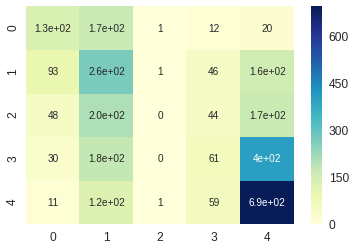

In [0]:
make_heat_map(conf_mx_pca_2)

## PCA - 16 Components

Now 16 components from the rotated set produced by the PCA function are used.

In [0]:
# limit PCA object to 16 components 
pca_sixteen = PCA(n_components=16)

# use pca object to fit & apply pca transformation to data
X_train_pca_16 = pca_sixteen.fit_transform(X_train_scaled)
X_test_pca_16 = pca_sixteen.transform(X_test_scaled)

In [19]:
log_clf_pca_16 = LogisticRegression(solver='lbfgs', multi_class='multinomial')
pca_16_model_score_train, pca_16_model_score_test, conf_mx_pca_16, class_report_pca_16 = train_model_and_score(log_clf, X_train_pca_16, y_train, X_test_pca_16, y_test)

print("Model Score Train: {}".format(round(pca_16_model_score_train,4)))
print("Model Score Test:  {}".format(round(pca_16_model_score_test, 4)))
print('\nConfustion Matrix\n', conf_mx_pca_16)
print('\nClassification Report\n', class_report_pca_16)

Model Score Train: 0.8426
Model Score Test:  0.8396

Confustion Matrix
 [[253  82   0   0   0]
 [ 55 441  65   0   0]
 [  0  53 346  64   0]
 [  0   0  41 581  46]
 [  0   0   0  61 824]]

Classification Report
               precision    recall  f1-score   support

         1.0       0.82      0.76      0.79       335
         2.0       0.77      0.79      0.78       561
         3.0       0.77      0.75      0.76       463
         4.0       0.82      0.87      0.85       668
         5.0       0.95      0.93      0.94       885

   micro avg       0.84      0.84      0.84      2912
   macro avg       0.82      0.82      0.82      2912
weighted avg       0.84      0.84      0.84      2912



The model performs now preforms on par with the original logistic model, using 10 less predictors than the original 26. This shows that using PCA can help simplify the feature space by removing the covariance between predictors, resulting in less data and therefore a small memory requirement.

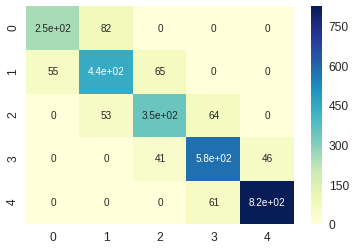

In [20]:
make_heat_map(conf_mx_pca_16)

The vector containing the cumulative percentage of variance explained by the the PCA components confirms our model results. Using only 2 components only captures 40% of the variance in the data, while using 16 captures nearly 100%. In fact we could bring it down to 13 and capture 95% of the variance.

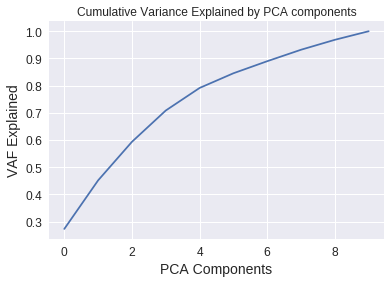

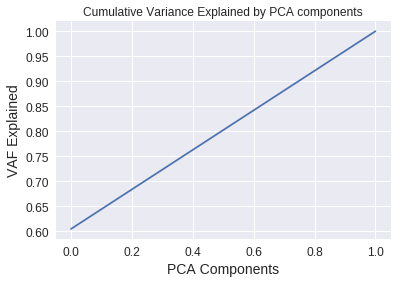

In [0]:
def pca_vaf_explained(pca_model):
  explained_variance = np.cumsum(pca_model.explained_variance_ / sum(pca_model.explained_variance_)).T
  plt.plot(explained_variance)  
  plt.title('Cumulative Variance Explained by PCA components')
  plt.xlabel('PCA Components')
  plt.ylabel('VAF Explained')
  plt.show()  
  
pca_vaf_explained(pca_sixteen)

pca_vaf_explained(pca_two)


In [0]:
!jupyter nbconvert --to html '$NOTEBOOK_FILE';